<a href="https://colab.research.google.com/github/rogerpanel/CV/blob/main/Transformer_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 58.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 139.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.6 MB/s eta 0:00:00


In [ ]:
pip install torch

In [ ]:
# Get ViT-PyTorch
!pip install --upgrade pytorch-pretrained-vit

  Preparing metadata (setup.py) ... done
  Created wheel for pytorch-pretrained-vit: filename=pytorch_pretrained_vit-0.0.7-py3-none-any.whl size=11116 sha256=759b95986245d1c9f3943f69993c9ddc82ede9419d50c87ad10620b041756a8e
  Stored in directory: /root/.cache/pip/wheels/2d/46/ad/12007be9d377d0fbf27ef75b6e47ed92832ab6b70dbf004b6f
Successfully built pytorch-pretrained-vit


In [ ]:
pip install soundfile

In [ ]:
pip install scikit-image

In [ ]:
#import Libraries
import torch
import librosa
import soundfile as sf
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import ViTModel, ViTConfig
from sklearn.manifold import TSNE
# import libraries
from torchvision.transforms import ToTensor
from pytorch_pretrained_vit import ViT

Some weights of the model checkpoint at google/vit-base-patch16-224 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MSE: 0.7873698
PSNR: 7.05881269957959
SSIM: 0.00463913963724059


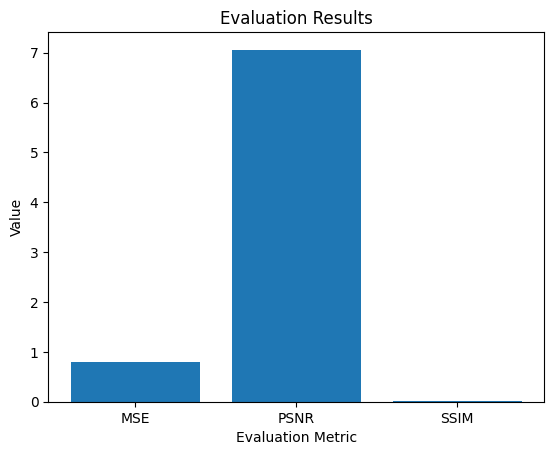

Reconstructed audio saved as /content/output_audio.wav


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:

# Constants
AUDIO_SAMPLE_RATE = 44100  # Sample rate of the original audio file
FRAME_LENGTH = 2048
HOP_LENGTH = 512

# Function to extract hidden audio information from stego-images in embedded batches
def extract_audio_from_stego_images(stego_images, patch_size, audio_length, batch_size):
    num_images = len(stego_images)
    extracted_audio_batches = []

    # Create a new ViT model with the desired image size
    model_name = 'google/vit-base-patch16-224'
    model = ViTModel.from_pretrained(model_name)

    for i in range(0, num_images, batch_size):
        batch_images = stego_images[i:i+batch_size]

        # Resize stego images to match the expected input size of the ViT model
        resized_stego_images = []
        for image in batch_images:
            resized_image = cv2.resize(image, (224, 224))
            resized_stego_images.append(resized_image)

        # Convert stego images to tensor
        tensor_stego_images = torch.stack([ToTensor()(image) for image in resized_stego_images])

        # Pass stego images through the ViT model to obtain audio embeddings
        audio_embeddings = model.forward(tensor_stego_images).last_hidden_state.squeeze().detach().numpy()

        # Reshape audio embeddings to match the patch arrangement
        audio_embeddings = audio_embeddings.reshape(audio_embeddings.shape[0], -1)

        # Extract the hidden audio information from the audio embeddings
        extracted_audio_batch = []
        for j in range(audio_embeddings.shape[0]):
            audio_embedding = audio_embeddings[j]
            patch_audio = audio_embedding[:audio_length]
            extracted_audio_batch.append(patch_audio)

        # Concatenate the extracted audio patches for the batch
        extracted_audio_batch = np.concatenate(extracted_audio_batch)
        extracted_audio_batches.append(extracted_audio_batch)

    # Concatenate the extracted audio patches for all batches
    extracted_audio = np.concatenate(extracted_audio_batches)

    return extracted_audio

# Function to resize or truncate the reconstructed audio to match the length of the original audio
def reconstruct_audio(extracted_audio, original_audio_length):
    reconstructed_audio = extracted_audio[:original_audio_length]
    return reconstructed_audio

# Example usage
# Load the stego images
stego_images = np.load('/content/image_npy_1.npy')

# Convert stego images to RGB color space
rgb_stego_images = []
for image in stego_images:
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    rgb_stego_images.append(rgb_image)

# Convert the RGB stego images back to a NumPy array
rgb_stego_images = np.array(rgb_stego_images)

# Assuming the patch size is equal to the height of the stego image
patch_size = rgb_stego_images.shape[1]

# Assuming the audio length is based on the number of frames in the stego image
audio_length = rgb_stego_images.shape[0] * FRAME_LENGTH

# Set the batch size for processing stego images
batch_size = 10

# Extract hidden audio information from stego-images
extracted_audio = extract_audio_from_stego_images(rgb_stego_images, patch_size, audio_length, batch_size)

# Load the original audio file
original_audio, _ = librosa.load('/content/1. male1a.wav', sr=AUDIO_SAMPLE_RATE)

# Resize or truncate the reconstructed audio to match the length of the original audio
reconstructed_audio = reconstruct_audio(extracted_audio, len(original_audio))

# Assuming you have defined the evaluate_decoding function for accuracy evaluation
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def evaluate_decoding(original_audio, reconstructed_audio):
    mse = np.mean((original_audio - reconstructed_audio) ** 2)
    psnr = peak_signal_noise_ratio(original_audio, reconstructed_audio)
    ssim = structural_similarity(original_audio, reconstructed_audio)
    return mse, psnr, ssim

# Evaluate the accuracy and reliability of the decoding process
mse, psnr, ssim = evaluate_decoding(original_audio, reconstructed_audio)

# Print the values
print("MSE:", mse)
print("PSNR:", psnr)
print("SSIM:", ssim)

# TO VISUALIZE THE EVALUATION:
# Create a bar plot
labels = ['MSE', 'PSNR', 'SSIM']
values = [mse, psnr, ssim]
plt.bar(labels, values)

# Add labels and title to the plot
plt.xlabel('Evaluation Metric')
plt.ylabel('Value')
plt.title('Evaluation Results')

# Show the plot
plt.show()

# Save the reconstructed audio
output_audio_file = '/content/output_audio.wav'
sf.write(output_audio_file, reconstructed_audio, AUDIO_SAMPLE_RATE, 'PCM_24')
print("Reconstructed audio saved as", output_audio_file)

# Directly Download the Extraction
from google.colab import files
files.download (output_audio_file)
